# **Project Report**
### Faranaz Surani
### PGD BATCH 5 – DATA SCIENCES & AI
### Course: DEEP LEARNING
### Teacher : SAJID MAJEED

# **Topic: Object Detection using YOLO**


In [ ]:
import torch
if torch.cuda.is_available():
    print("CUDA is available. GPU will be used.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. GPU will be used.


In [ ]:
!pip install ultralytics
!pip install ipywidgets
!pip install matplotlib
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.8/882.8 kB 48.5 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
import ipywidgets as widgets
from IPython.display import display

In [ ]:
import torch
import cv2
import numpy as np
import os
import time
from ultralytics import YOLO
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display, clear_output


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# --- Load YOLO Model ---
def load_model(model_name, device="cpu"):
    try:
        if model_name.lower() == "yolov8":
            model = YOLO('yolov8n.pt')  # You can change to yolov8s.pt, yolov8m.pt, etc.
        else:
            model_path = f'./{model_name.lower()}.pt'
            if os.path.exists(model_path):
                model = YOLO(model_path)
            else:
                print(f"Model {model_name} not found.")
                return None

        if device.lower() in ['gpu', 'cuda'] and torch.cuda.is_available():
            model.to('cuda')
            print("Model loaded on GPU.")
        else:
            model.to('cpu')
            print("Model loaded on CPU.")

        return model

    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# --- Utility: Resize Image ---
def resize_image(image, height):
    aspect_ratio = image.shape[1] / image.shape[0]  # width / height
    new_width = int(height * aspect_ratio)
    return cv2.resize(image, (new_width, height))

# --- Perform Prediction ---
def predict(model, img, conf_thresh=0.5):
    results = model.predict(img, conf=conf_thresh)
    return results

# --- Draw Bounding Boxes ---
def draw_boxes(img, results, conf_thresh=0.5, thickness=2, font_scale=0.5):
    detected_objects = []
    # Generate a color map for each class ID (random colors)
    num_classes = 80  # Assume 80 classes (e.g., COCO dataset). Adjust according to your dataset.
    colors = np.random.randint(0, 255, size=(num_classes, 3), dtype="uint8")

    for result in results:
        for box in result.boxes:
            # Extract bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = box.conf[0].cpu().numpy().astype(float)
            class_id = int(box.cls[0].cpu().numpy())

            if conf >= conf_thresh:
                # Get a random color for each class_id
                color = [int(c) for c in colors[class_id % len(colors)]]

                # Draw rectangle for bounding box with the generated color
                cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

                label = f"{result.names[class_id]}: {conf:.2f}"

                # Put the label text with the same color
                cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

                detected_objects.append(result.names[class_id])

    return img, detected_objects


# --- Display Image ---
def display_image(img, title="Image"):
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


In [ ]:
def run_object_detection():
    # Determine device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load YOLO model
    version = "yolov8"  # Change as needed (e.g., 'yolov8s', 'yolov8m', etc.)
    confidence_threshold = 0.5

    model = load_model(version, device)

    if not model:
        print("Failed to load the model. Please check the model name and try again.")
        return

    # Upload image
    print("Please upload an image file for object detection:")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded.")
        return

    # Get the uploaded file name
    file_name = next(iter(uploaded))
    print(f"Uploaded file: {file_name}")

    try:
        # Read the image file
        image_data = uploaded[file_name]
        nparr = np.frombuffer(image_data, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        if img is None:
            print("Failed to read the image. Please upload a valid image file.")
            return

        # Resize for display
        resized_img = resize_image(img, 500)

        # Perform prediction
        start_time = time.time()
        results = predict(model, resized_img, confidence_threshold)
        prediction_time = time.time() - start_time

        # Draw bounding boxes on the image
        output_img, detected_objects = draw_boxes(resized_img.copy(), results, confidence_threshold)

        # Display original and processed images
        print("Original Image:")
        display_image(resized_img, title="Original Image")
        print("Processed Image:")
        display_image(output_img, title=f"Processed Image - Prediction time: {prediction_time:.2f} seconds")

        # Display detected objects
        if detected_objects:
            print(f"Detected objects: {', '.join(detected_objects)}")
        else:
            print("No objects detected.")

    except Exception as e:
        print(f"An error occurred during processing: {e}")


Using device: cuda
Model loaded on GPU.
Please upload an image file for object detection:


Saving 448176679_884161103727389_7049711504765561510_n.jpg to 448176679_884161103727389_7049711504765561510_n (3).jpg
Uploaded file: 448176679_884161103727389_7049711504765561510_n (3).jpg

0: 480x640 3 persons, 1 bowl, 1 cake, 1 dining table, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
Original Image:


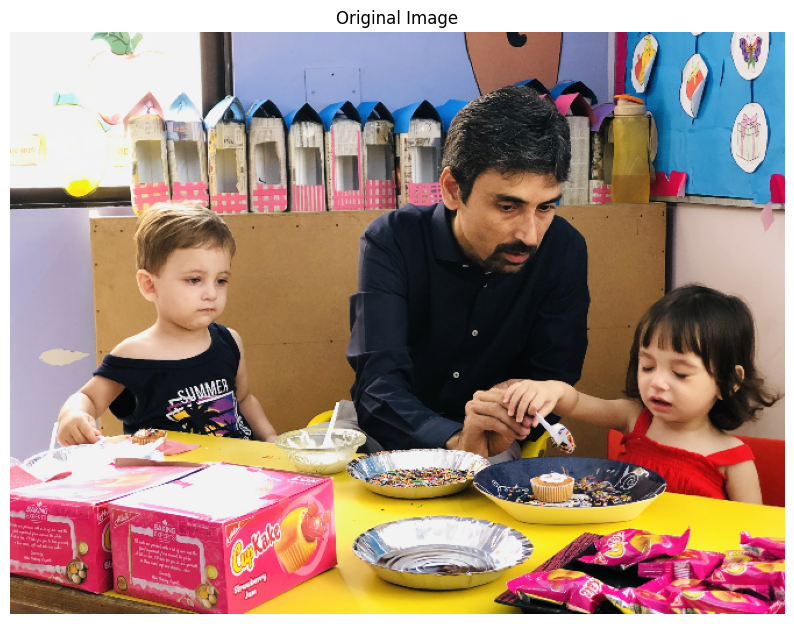

Processed Image:


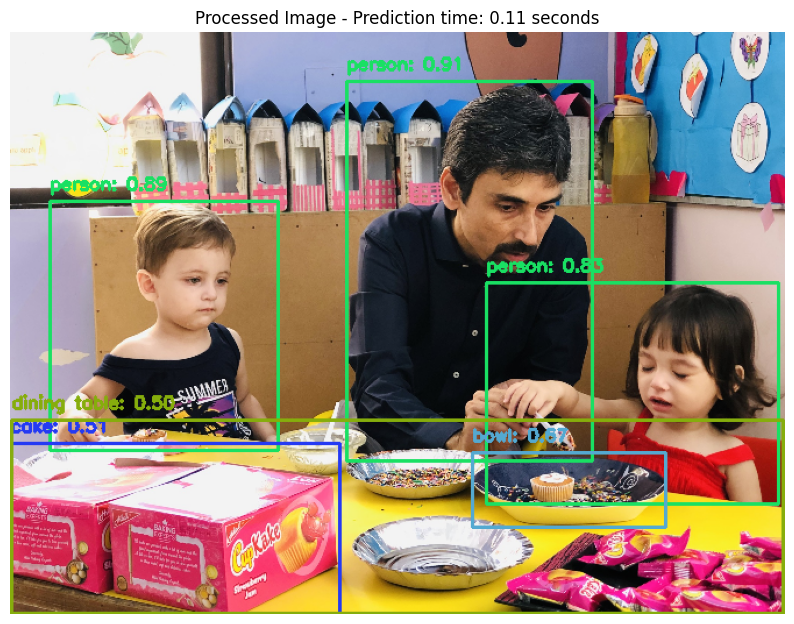

Detected objects: person, person, person, bowl, cake, dining table

--- Object Detection Summary ---
Summary of detected objects:
person: 3
bowl: 1
cake: 1
dining table: 1


In [ ]:
run_object_detection()

Using device: cuda
Model loaded on GPU.
Please upload an image file for object detection:


Saving alyy-dady.jpg to alyy-dady.jpg
Uploaded file: alyy-dady.jpg

0: 640x480 2 persons, 40.2ms
Speed: 2.1ms preprocess, 40.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)
Original Image:


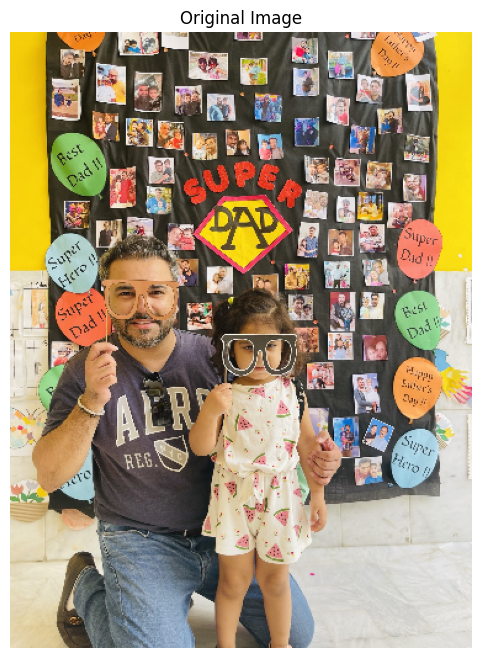

Processed Image:


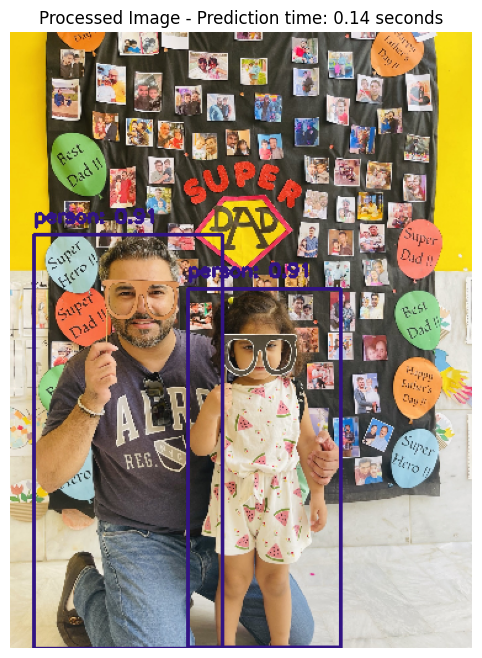

Detected objects: person, person

--- Object Detection Summary ---
Summary of detected objects:
person: 2


In [20]:
run_object_detection()